In [1261]:
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [1262]:
# root dfs
cust = pd.read_feather('created_data/customer.feather')
acc = pd.read_feather('created_data/account.feather')
tran = pd.read_feather('created_data/transactions.feather')


#account info
acc_cheq = pd.read_feather('created_data/account_checking.feather')
acc_cred = pd.read_feather('created_data/account_credit.feather')
acc_save = pd.read_feather('created_data/account_saving.feather')

#transaction info
tran_cheq = pd.read_feather('created_data/transaction_checking.feather')
tran_cred = pd.read_feather('created_data/transaction_credit.feather')
tran_save = pd.read_feather('created_data/transaction_saving.feather')


# <u>Feature Engi - Customer Cluster</u>

In [1263]:
cust

,cust_id,income,age,years_with_bank,nbr_children,gender,marital_status,name_prefix,postal_code,city_name,state_code
0,1362691,26150,46,5,1,M,2,,89194,Las Vegas,NV
1,1362487,6605,71,1,0,M,2,,90159,Los Angeles,CA
2,1363160,18548,38,8,0,F,1,,90024,Los Angeles,CA
3,1362752,47668,54,3,0,F,1,,90172,Los Angeles,CA
4,1362548,44554,59,9,2,F,4,,10138,New York City,NY
...,...,...,...,...,...,...,...,...,...,...,...
742,1363324,14795,36,6,1,F,4,,90016,Los Angeles,CA
743,1362895,26387,56,6,1,M,2,,10126,New York City,NY
744,1362569,61300,50,0,2,M,2,,87194,Albuquerque,NM
745,1363364,15100,37,7,0,F,2,,35241,Birmingham,AL


first cluster, 4d before dummies

In [1264]:
clust_1 = cust[['income','age','gender','state_code']]

convert to dummies and clean a bit

In [1265]:
# simple boolean dummy for gender
clust_1['gender_dummy'] = clust_1['gender'].replace({'M':1,'F':0})

# expand state dummy into boolean dummy
df_dummy = pd.get_dummies(clust_1['state_code'])

# concat and drop old dummies
clust_1 = pd.concat([clust_1,df_dummy], axis=1)
clust_1 = clust_1.drop(['gender','state_code'],axis=1)


# People under 18 have no income, can't get credit cards and are not valuable to our data.
clust_1 = clust_1[clust_1['age'] > 18]

C:\Users\malco\AppData\Local\Temp\ipykernel_17664\4042773886.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [1266]:
px.scatter(clust_1,clust_1.groupby('age').income.mean().values,np.sort(clust_1.age.unique()))

In [1267]:
px.scatter_3d(clust_1, x='age',y='income', z='gender_dummy')

^ This pattern will come up later

# Scaling

In [1268]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

In [1269]:
clust_1

,income,age,gender_dummy,AL,AZ,CA,CO,DC,FL,GA,...,NY,OH,OK,OR,PA,TN,TX,VA,WA,WI
0,26150,46,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6605,71,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,18548,38,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,47668,54,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,44554,59,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740,2289,34,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
742,14795,36,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
743,26387,56,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
744,61300,50,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We found out a robust scaler is much better than standard

In [1270]:
robScale = RobustScaler()

In [1271]:
robScale.fit(clust_1)

RobustScaler()

In [1272]:
x = robScale.transform(clust_1)

In [1273]:
km = KMeans(n_clusters=3,
            init='k-means++',
            n_init=10,
            random_state=0)

In [1274]:
y_km = km.fit_predict(x)

In [1275]:
def plot_clusters(x,y_res,plt_cluster_centers = False):
    x_centroids = []
    y_centroids = []

    for cluster in set(y_res):
        X = x[y_res == cluster,0]
        Y = x[y_res == cluster,1]

        x_centroids.append(np.mean(X))
        y_centroids.append(np.mean(Y))
        plt.scatter(X,
                    Y,
                    s=50,
                    marker='s',
                    label=f'cluster {cluster}')
    if plt_cluster_centers:
        plt.scatter(x_centroids,
                    y_centroids,
                    marker='*',
                    c='magenta',
                    s=250,
                    label='centroids')
    plt.legend()
    plt.grid()
    plt.show()

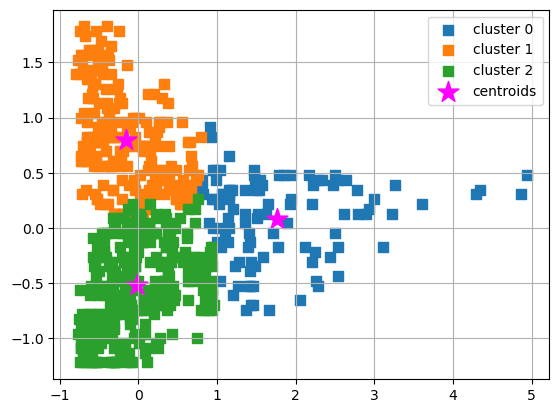

In [1276]:
plot_clusters(x,y_km,plt_cluster_centers=True)

In [1277]:
def plot_elbow(X, max_clusters = 10):
    joints = []
    for i in range(1,max_clusters+1):
        km = KMeans(n_clusters=i,
                    init='k-means++',
                    n_init=10,
                    random_state=0)
        km.fit(X)
        joints.append(km.inertia_)
    tmp_df = pd.DataFrame({'Number of Clusters' : range(1,max_clusters+1),'Joints':joints})
    fig=px.line(tmp_df, x= 'Number of Clusters',y='Joints',markers=True)
    fig.show()
    

In [1278]:
plot_elbow(x)

c:\Users\malco\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.



In [1279]:
from sklearn.metrics import silhouette_score

In [1280]:
def plot_elbow_sil(X, max_clusters = 10):
    joints = []
    for i in range(2,max_clusters+2):
        km = KMeans(n_clusters=i,
                    init='k-means++',
                    n_init=10,
                    random_state=0)
        km.fit(X)
        y_db = km.fit_predict(X)
        joints.append(silhouette_score(X,y_db))
    tmp_df = pd.DataFrame({'Number of Clusters' : range(1,max_clusters+1),'Joints':joints})
    fig=px.line(joints)
    fig.show()

In [1281]:
clust_1['cluster'] = y_km

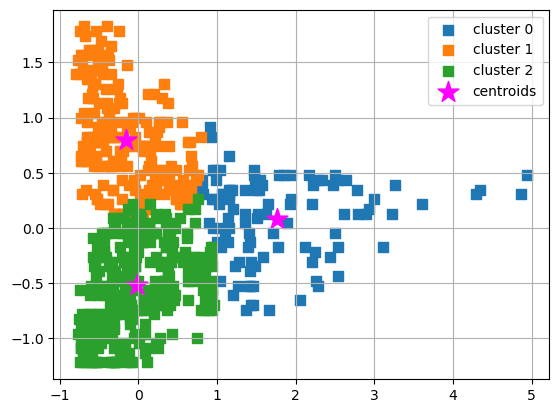

In [1282]:
plot_clusters(x,y_km,plt_cluster_centers=True)

# Experiment with PCA with clust_1

In [1283]:
from sklearn.decomposition import PCA

In [1284]:
robScale.fit(clust_1)
x = robScale.transform(clust_1)

In [1285]:
pca = PCA()
pca.fit(x)

x_pca = pca.transform(x)

In [1286]:
x_pca.shape

(625, 37)

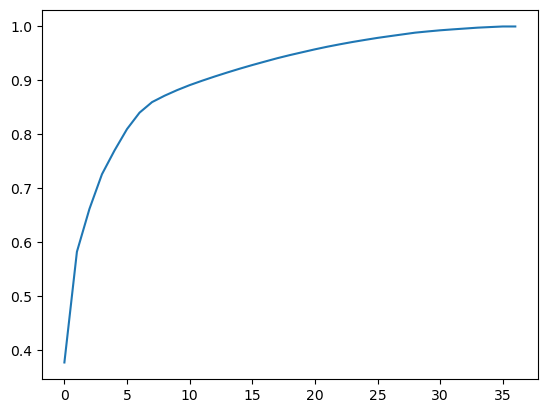

In [1287]:

plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [1288]:
pca = PCA(n_components=4)
pca.fit(x)

x_pca = pca.transform(x)

In [1289]:
df = pd.DataFrame(x_pca)
df.columns = ['PC1','PC2','PC3','PC4']

In [1290]:
px.scatter_3d(df, x='PC1',y='PC2',z='PC3', color='PC4')

PC3 is mainly representing gender,
PC2 is mainly representing age,
PC1 is mainly representing income,
PC4 is mainly representing people residing in California
(California has the highest occurence of states at ~140)

# Now we will try a more simple cluster

In [1291]:
clust_2_simple = clust_1[['income','age','gender_dummy']]

In [1292]:
robScale.fit(clust_2_simple)

RobustScaler()

In [1293]:
x = robScale.transform(clust_2_simple)

In [1294]:
km = KMeans(n_clusters=3,
            n_init=10,
            random_state=0)

In [1295]:
y_xr = km.fit_predict(x)
clust_2_simple = pd.concat([clust_2_simple,pd.Series(y_xr, name='cluster')],axis=1)

In [1296]:
set(y_xr)

{0, 1, 2}

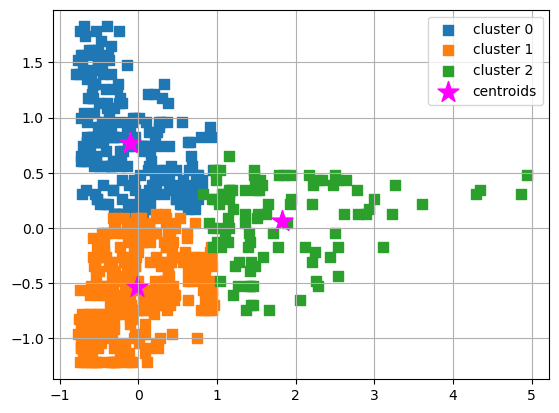

In [1297]:
plot_clusters(x,y_xr,plt_cluster_centers=True)

In [1298]:
plot_elbow(x)

c:\Users\malco\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.



# PCA for simple cluster

In [1299]:
pca = PCA(n_components=3)
pca.fit(x)

PCA(n_components=3)

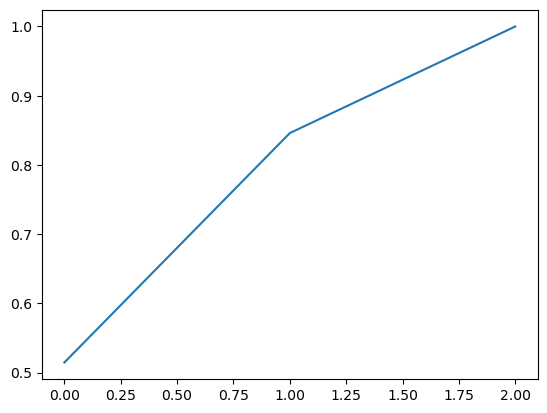

In [1300]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

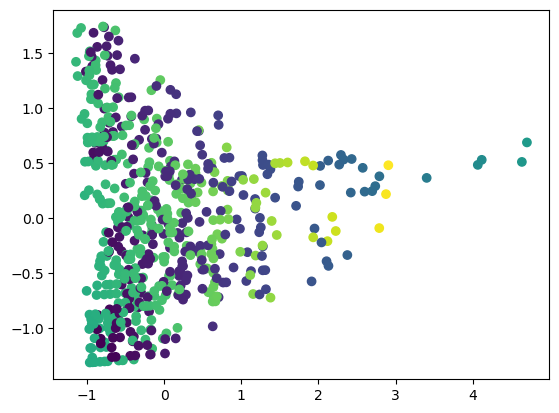

In [1301]:
pca = PCA(n_components=3)
pca.fit(x)
x_pca = pca.transform(x)
plt.scatter(x_pca[:,0],x_pca[:,1],c=x_pca[:,2])

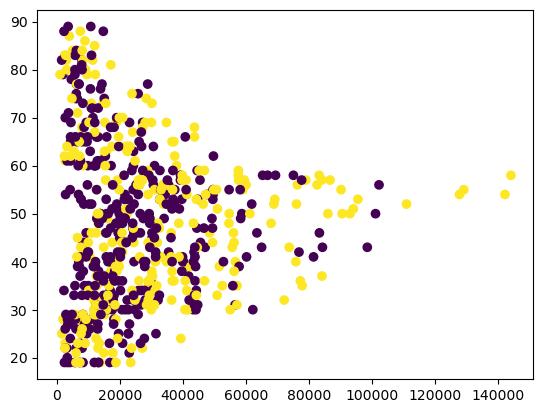

In [1302]:
plt.scatter(clust_2_simple.income,clust_2_simple.age,c=clust_2_simple.gender_dummy)

In [1303]:
pca = PCA(n_components=2)
pca.fit(x)
x_pca = pca.transform(x)

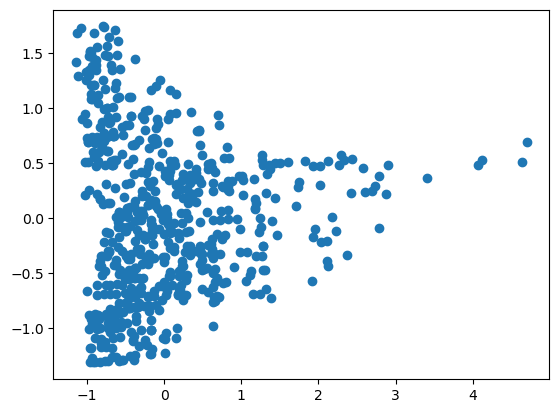

In [1304]:
plt.scatter(x_pca[:,0],x_pca[:,1])

# Most Intricate Dataframe

In [1305]:
cust.describe()

,cust_id,income,age,years_with_bank,nbr_children,marital_status,postal_code
count,7.470000e+02,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000
mean,1.362991e+06,22728.281124,42.479250,3.907631,0.714859,1.882195,59502.690763
std,2.925255e+02,22207.221405,19.114879,2.675634,1.103410,0.892051,31205.926508
min,1.362480e+06,0.000000,13.000000,0.000000,0.000000,1.000000,2149.000000
25%,1.362732e+06,7118.500000,28.000000,2.000000,0.000000,1.000000,33145.000000
50%,1.362993e+06,17242.000000,42.000000,4.000000,0.000000,2.000000,64132.000000
75%,1.363244e+06,31338.000000,56.000000,6.000000,1.000000,2.000000,90082.000000
max,1.363495e+06,144157.000000,89.000000,9.000000,5.000000,4.000000,98186.000000


In [1306]:
complex_clust = cust[['income','age','years_with_bank','nbr_children','gender','marital_status','name_prefix','postal_code','state_code']]

In [1307]:
cust.describe()

,cust_id,income,age,years_with_bank,nbr_children,marital_status,postal_code
count,7.470000e+02,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000
mean,1.362991e+06,22728.281124,42.479250,3.907631,0.714859,1.882195,59502.690763
std,2.925255e+02,22207.221405,19.114879,2.675634,1.103410,0.892051,31205.926508
min,1.362480e+06,0.000000,13.000000,0.000000,0.000000,1.000000,2149.000000
25%,1.362732e+06,7118.500000,28.000000,2.000000,0.000000,1.000000,33145.000000
50%,1.362993e+06,17242.000000,42.000000,4.000000,0.000000,2.000000,64132.000000
75%,1.363244e+06,31338.000000,56.000000,6.000000,1.000000,2.000000,90082.000000
max,1.363495e+06,144157.000000,89.000000,9.000000,5.000000,4.000000,98186.000000


In [1308]:
complex_clust['parent'] = complex_clust['nbr_children'].transform(lambda x: x > 0).map({True:1,False:0})

C:\Users\malco\AppData\Local\Temp\ipykernel_17664\1918214793.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [1309]:
complex_clust['gender'] = complex_clust['gender'].replace({'M':1,'F':0})

C:\Users\malco\AppData\Local\Temp\ipykernel_17664\3123557935.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [1310]:
complex_clust['has_prefix'] = complex_clust['name_prefix'].transform(lambda x: x != '').map({True:1,False:0})

In [1311]:
cust[ (cust.postal_code.astype(str).str.startswith('7'))].state_code.value_counts()

TX    83
OK    16
NJ    12
LA     3
Name: state_code, dtype: int64

MA and NJ are problems. Switch everything that has a length of 4 to start with 1

In [1312]:
complex_clust.loc[(complex_clust.postal_code.astype(str).str.len()==4),'postal_code'] = 1

In [1313]:
complex_clust['postal_code'] = complex_clust['postal_code'].astype(str).str[0]

In [1314]:
tmp_dummies = pd.get_dummies(complex_clust['state_code'])

In [1315]:
complex_clust = pd.concat([complex_clust,tmp_dummies], axis=1)

In [1316]:
post_dummies = pd.get_dummies(complex_clust.postal_code,prefix='region')


In [1317]:
complex_clust = pd.concat([complex_clust,post_dummies],axis=1)

In [1318]:
complex_clust.drop(['nbr_children','name_prefix','postal_code','state_code'],axis=1,inplace=True)

49 dimensions

onto PCA

In [1319]:
pca = PCA()
pca.fit(complex_clust)

PCA()

In [1320]:
x = pca.transform(complex_clust)

In [1321]:
pca.explained_variance_ratio_

array([9.99999283e-01, 6.97076783e-07, 1.40472692e-08, 1.54330711e-09,
       8.46091327e-10, 5.67748126e-10, 5.10448608e-10, 4.15095988e-10,
       3.90763697e-10, 2.77668151e-10, 2.54820258e-10, 1.90956435e-10,
       1.58641555e-10, 1.21607433e-10, 1.00369493e-10, 9.20654494e-11,
       8.27345338e-11, 6.53663637e-11, 6.26983606e-11, 5.27250838e-11,
       4.52407569e-11, 4.12902758e-11, 3.98831455e-11, 3.86870857e-11,
       3.81306293e-11, 3.75168475e-11, 2.70682790e-11, 2.67503639e-11,
       2.43995640e-11, 2.28907430e-11, 2.22158286e-11, 1.82301998e-11,
       1.43903541e-11, 1.41757710e-11, 1.29410973e-11, 1.23505535e-11,
       1.05994740e-11, 8.11690443e-12, 6.32523935e-12, 9.98401322e-33,
       9.98401322e-33, 9.98401322e-33, 9.98401322e-33, 9.98401322e-33,
       9.98401322e-33, 9.98401322e-33, 9.98401322e-33, 9.98401322e-33,
       9.98401322e-33])

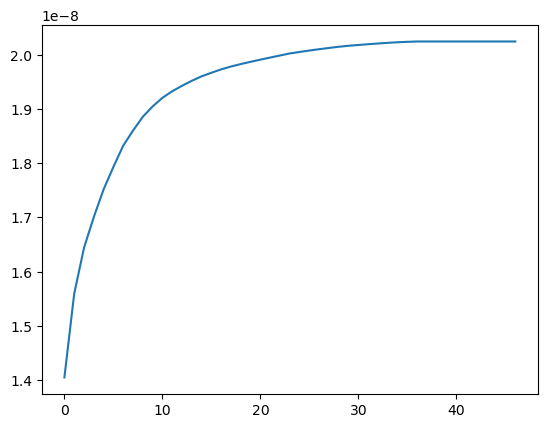

In [1322]:
plt.plot(np.cumsum(pca.explained_variance_ratio_[2:]))

In [1323]:
pca = PCA(n_components=10)
pca.fit(complex_clust)
x = pca.transform(complex_clust)

In [1324]:
plot_elbow(x)

c:\Users\malco\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.



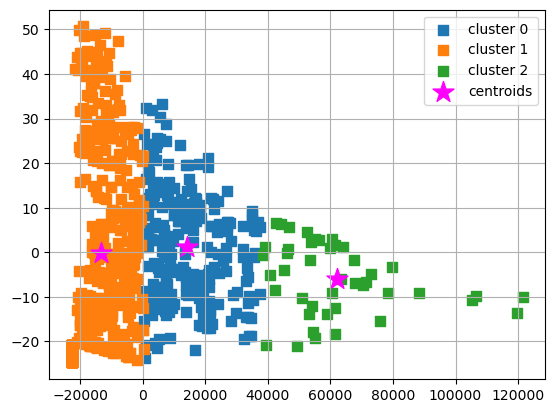

In [1325]:
km = KMeans(n_clusters=3,
            n_init=10,
            random_state=0)
y = km.fit_predict(x)
plot_clusters(x,y,plt_cluster_centers=True)

In [1326]:
tmp_srs = pd.Series(y,name='cluster')

In [1327]:
complex_clust = pd.concat([complex_clust,tmp_srs],axis=1,)

In [1328]:
complex_clust.columns = ['income', 'age', 'years_with_bank', 'gender', 'marital_status',
       'parent', 'has_prefix', 'AL', 'AZ', 'CA', 'CO', 'DC', 'FL', 'GA', 'HI',
       'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'MI', 'MN', 'MO', 'NB', 'NC',
       'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'TN', 'TX', 'VA', 'WA',
       'WI', 'near_NY', 'near_VA', 'near_FL', 'near_OH', 'near_MN',
       'near_MI', 'near_TX', 'near_CO', 'near_CA', 'cluster']

## Comparing clusters

- 1 = north east / New York
- 2 = east / Virginia
- 3 = south east / Florida
- 4 = center east / Ohio
- 5 = center north east / Minnesota
- 6 = center center east / missouri
- 7 = south / Texas
- 8 = south west / Colorado
- 9 = west west / California

In [1337]:
complex_clust[complex_clust['cluster'] == 2].describe()

,income,age,years_with_bank,gender,marital_status,parent,has_prefix,AL,AZ,CA,...,near_NY,near_VA,near_FL,near_OH,near_MN,near_MI,near_TX,near_CO,near_CA,cluster
count,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.0,44.000000,44.000000,...,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.0
mean,84921.363636,49.590909,3.954545,0.636364,2.227273,0.522727,0.454545,0.0,0.022727,0.250000,...,0.181818,0.045455,0.068182,0.068182,0.022727,0.159091,0.136364,0.068182,0.250000,2.0
std,20145.032926,7.758920,2.769892,0.486607,0.885638,0.505258,0.503686,0.0,0.150756,0.438019,...,0.390154,0.210707,0.254972,0.254972,0.150756,0.369989,0.347142,0.254972,0.438019,0.0
min,61300.000000,30.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0
25%,71503.500000,43.000000,2.000000,0.000000,2.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0
50%,80283.000000,52.000000,3.500000,1.000000,2.000000,1.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0
75%,91209.000000,56.000000,6.000000,1.000000,3.000000,1.000000,1.000000,0.0,0.000000,0.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,2.0
max,144157.000000,58.000000,8.000000,1.000000,4.000000,1.000000,1.000000,0.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.0


In [1357]:
clust_1[clust_1['cluster'] == 1].describe()

,income,age,gender_dummy,AL,AZ,CA,CO,DC,FL,GA,...,OH,OK,OR,PA,TN,TX,VA,WA,WI,cluster
count,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.0,...,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.0,212.000000,212.000000,212.0
mean,16978.183962,65.254717,0.415094,0.009434,0.051887,0.127358,0.023585,0.004717,0.014151,0.0,...,0.047170,0.023585,0.009434,0.037736,0.028302,0.108491,0.0,0.018868,0.056604,1.0
std,10697.265328,10.199490,0.493905,0.096898,0.222323,0.334163,0.152111,0.068680,0.118393,0.0,...,0.212504,0.152111,0.096898,0.191008,0.166226,0.311735,0.0,0.136381,0.231631,0.0
min,1039.000000,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.0
25%,7954.500000,57.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.0
50%,14534.000000,64.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.0
75%,25717.500000,72.250000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.0
max,40795.000000,89.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.0


In [1362]:
clust_2_simple[clust_2_simple['cluster'] == 0].describe()

,income,age,gender_dummy,cluster
count,186.000000,186.000000,186.000000,226.0
mean,26500.462366,47.623656,0.473118,0.0
std,22115.066255,16.543743,0.500624,0.0
min,2442.000000,19.000000,0.000000,0.0
25%,12075.250000,35.250000,0.000000,0.0
50%,20512.000000,46.000000,0.000000,0.0
75%,32026.250000,58.000000,1.000000,0.0
max,127848.000000,88.000000,1.000000,0.0


clust_2_simple did a very poor job of clustering based on demographics and instead took 3 clusters having about the same pattern. Cluster 1 complex cluster did a much better job. All clusters chose income as their most important component.

# Based on Banking Behaviour

,tran_id,acct_nbr,tran_amt,principal_amt,interest_amt,new_balance,tran_date,tran_time,tran_code
0,27,13625623,0.00,0.00,0.0,3753.34,1995-10-21,12.0,IQ
1,97,13628392,0.00,0.00,0.0,254.49,1995-02-05,15.0,IQ
2,21,13630842,-97.57,-97.57,0.0,3819.56,1995-07-23,NaN,WD
3,44,13631412,-0.15,-0.15,0.0,224.05,1995-01-30,NaN,FK
4,31,13625722,0.00,0.00,0.0,240.55,1995-01-25,20.0,IQ
...,...,...,...,...,...,...,...,...,...
77575,77,13631752,-95.71,-95.71,0.0,95.71,1995-02-14,16.0,TR
77576,94,13626772,-93.90,-93.90,0.0,824.36,1995-03-11,NaN,WD
77577,42,13625262,-10.35,-10.35,0.0,10.36,1995-08-26,NaN,WD
77578,98,13627052,-423.80,-423.80,0.0,162.28,1995-06-13,11.0,WD
